In [1]:
import re
import os
import string
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from datasets import Dataset
import torch
import seaborn as sns
import random
from torch.nn import CrossEntropyLoss
from torch.utils.data import WeightedRandomSampler, DataLoader
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

import optuna
import ray
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune import CLIReporter



In [2]:
def set_seed(seed):
    # Set the seed for Python random module
    random.seed(seed)
    # Set the seed for NumPy
    np.random.seed(seed)
    # Set the seed for PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU
    torch.backends.cudnn.deterministic = True  # Ensures deterministic behavior
    torch.backends.cudnn.benchmark = False 

In [3]:
df = pd.read_csv('longerdataset.csv')
data = df.iloc[:,1:3]
dataset = Dataset.from_pandas(data)

In [4]:
seed = 123
set_seed(seed)
batch_size =32

In [5]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
def tokenize_function(examples):
    return tokenizer(
        examples["text_comments"],  # Adjust the key to match your dataset
        padding="max_length",
        truncation=True,
        max_length=50
    )

# Tokenize dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Rename the label column for compatibility
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

# Set dataset format for PyTorch
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Train-validation-test split
train_val_split = tokenized_dataset.train_test_split(test_size=0.2, seed=seed)
train_split = train_val_split["train"].train_test_split(test_size=0.25, seed=seed)

# Assign splits
train_dataset = train_split["train"]
val_dataset = train_split["test"]
test_dataset = train_val_split["test"]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [7]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)  # Get predicted class

    # Calculate precision, recall, F1, and accuracy
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted", zero_division=0)
    acc = accuracy_score(labels, predictions)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [8]:
train_labels = np.array(train_dataset['labels'])

# Get all unique classes in the dataset
unique_classes = np.unique(train_labels)
class_weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

In [9]:
# Assuming class_weights is a tensor on the GPU
class_weights_cpu = class_weights.cpu()  # Move the tensor to CPU

# Assign a weight to each sample based on its class
sample_weights = np.array([class_weights_cpu[label].item() for label in train_labels])  # Convert each weight to a scalar and then to a numpy array
generator = torch.Generator().manual_seed(seed)
# Create a sampler using these weights
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True,generator=generator)


In [10]:
train_dataloader = DataLoader(
    train_dataset,
    sampler=sampler,
    batch_size=batch_size
)

In [11]:
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, sampler=None, seed=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights  # Store the class weights
        self.sampler = sampler  # Store the sampler
        self.seed = seed  # Store the seed

    def get_train_dataloader(self):
    # Override this method to pass the sampler into the DataLoader
    # Use the sampler created earlier with the fixed seed generator
        train_dataloader = DataLoader(
        self.train_dataset,
        batch_size=self.args.train_batch_size,
        sampler=self.sampler,  # Pass the sampler here (which already uses the fixed generator)
    )
        return train_dataloader

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        # Forward pass through the model
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        
        # Get the number of labels from model config
        num_labels = model.config.num_labels
        
        # Apply the loss function with class weights
        loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits.view(-1, num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

In [12]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",  # Evaluate at the end of every epoch
    learning_rate=1e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.001,
    logging_dir="./logs",
    logging_steps=50,  # Log every 50 steps
    save_strategy="epoch",  # Save checkpoints at the end of each epoch
    load_best_model_at_end=True,  # Automatically load the best model based on validation
    metric_for_best_model="accuracy",  # Metric to determine the best model
    greater_is_better=True,  # Specify if higher metric is better
    seed=seed,  # Set the seed for reproducibility
)


trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    class_weights=class_weights,
    sampler=sampler,  # Pass the sampler here
    compute_metrics=compute_metrics  # Assuming compute_metrics is defined
)

C:\Users\Paulo John Mercado\AppData\Local\Temp\ipykernel_32012\1403073069.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


In [13]:
trainer.train()

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.6747602820396423, 'eval_accuracy': 0.57, 'eval_precision': 0.6536703296703297, 'eval_recall': 0.57, 'eval_f1': 0.5665138624762285, 'eval_runtime': 0.2193, 'eval_samples_per_second': 455.926, 'eval_steps_per_second': 31.915, 'epoch': 1.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.7137752771377563, 'eval_accuracy': 0.38, 'eval_precision': 0.1444, 'eval_recall': 0.38, 'eval_f1': 0.20927536231884059, 'eval_runtime': 0.2208, 'eval_samples_per_second': 452.982, 'eval_steps_per_second': 31.709, 'epoch': 2.0}
{'loss': 0.6592, 'grad_norm': 6.158933639526367, 'learning_rate': 4.736842105263158e-05, 'epoch': 2.63}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.755435585975647, 'eval_accuracy': 0.66, 'eval_precision': 0.6493333333333333, 'eval_recall': 0.66, 'eval_f1': 0.6503030303030303, 'eval_runtime': 0.2188, 'eval_samples_per_second': 457.021, 'eval_steps_per_second': 31.991, 'epoch': 3.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.6445053815841675, 'eval_accuracy': 0.67, 'eval_precision': 0.7020968387354942, 'eval_recall': 0.67, 'eval_f1': 0.6747767992711813, 'eval_runtime': 0.2185, 'eval_samples_per_second': 457.578, 'eval_steps_per_second': 32.03, 'epoch': 4.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.6221246719360352, 'eval_accuracy': 0.68, 'eval_precision': 0.7088, 'eval_recall': 0.68, 'eval_f1': 0.6846753246753247, 'eval_runtime': 0.353, 'eval_samples_per_second': 283.312, 'eval_steps_per_second': 19.832, 'epoch': 5.0}
{'train_runtime': 129.0389, 'train_samples_per_second': 11.624, 'train_steps_per_second': 0.736, 'train_loss': 0.5723730990761204, 'epoch': 5.0}


TrainOutput(global_step=95, training_loss=0.5723730990761204, metrics={'train_runtime': 129.0389, 'train_samples_per_second': 11.624, 'train_steps_per_second': 0.736, 'total_flos': 38541658500000.0, 'train_loss': 0.5723730990761204, 'epoch': 5.0})

In [14]:
metrics = trainer.evaluate(eval_dataset=test_dataset)
predictions_output = trainer.predict(test_dataset)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
example = trainer.attention_weights[0]
input_ids = example["input_ids"][0]
attention = example["attention"]
model_view(attention, tokenizer, input_ids)

TypeError: 'int' object is not callable

In [15]:
print(metrics)

{'eval_loss': 0.5050376653671265, 'eval_accuracy': 0.83, 'eval_precision': 0.8305454545454546, 'eval_recall': 0.83, 'eval_f1': 0.8301892904140096, 'eval_runtime': 0.4083, 'eval_samples_per_second': 244.939, 'eval_steps_per_second': 17.146, 'epoch': 5.0}


In [16]:
logits = predictions_output.predictions  # shape (num_samples, num_classes)
labels = predictions_output.label_ids    # shape (num_samples,)

# Convert logits to predicted class labels (argmax)
predicted_labels = np.argmax(logits, axis=-1)


# Compute confusion matrix
conf_matrix = confusion_matrix(labels, predicted_labels)


In [17]:


# Print confusion matrix to check
print("Confusion Matrix:\n", conf_matrix)
print(classification_report(labels, predicted_labels))

Confusion Matrix:
 [[47  9]
 [ 8 36]]
              precision    recall  f1-score   support

           0       0.85      0.84      0.85        56
           1       0.80      0.82      0.81        44

    accuracy                           0.83       100
   macro avg       0.83      0.83      0.83       100
weighted avg       0.83      0.83      0.83       100



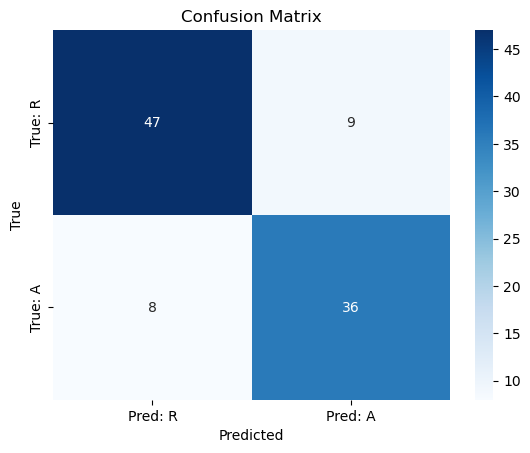

In [18]:
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Pred: R', 'Pred: A'], 
                yticklabels=['True: R', 'True: A'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#trainer.save_model(output_dir='./saved_model')
#tokenizer.save_pretrained('./saved_model')

('./saved_model\\tokenizer_config.json',
 './saved_model\\special_tokens_map.json',
 './saved_model\\vocab.txt',
 './saved_model\\added_tokens.json',
 './saved_model\\tokenizer.json')

In [ ]:
#trainedmodel = AutoModelForSequenceClassification.from_pretrained('./saved_model', output_attentions=True)

# Load the tokenizer
#trainedtokenizer = AutoTokenizer.from_pretrained('./saved_model')